In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 20}
matplotlib.rc('font', **font)


from csr2d.kick_transient import compute_dist_grid, compute_potential_grids, boundary_convolve

import time

import concurrent.futures as cf

#import warnings
#warnings.filterwarnings("ignore")

import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

### Yunhai's beam for transient wakes

In [2]:
# Yunhai's beam for transient wakes

gamma = 5000
rho = 1.5 # Bend radius in m

# Total charge
Nb = 6.25e9
Q = e_charge * Nb

## Additional parameters
beta = (1-1/gamma**2)**(1/2)
mc2 = 510998.950
p0c = gamma * beta * mc2  # in eV

# fix random seed 
np.random.seed(0)

# Number of macro particles
Np = 1000000

# charge of one macro-particle
charges = np.ones(Np)*Q/Np  

# Beam emittance
norm_emit_x = 1e-6           # in m
emit_x = norm_emit_x / gamma # in m

sigma_x = 50e-6
sigma_xp = emit_x / sigma_x
sigma_y = 0
sigma_yp = 0
sigma_z  = 50e-6
sigma_delta = 0

beam = np.zeros((6, Np))
beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))
beam[2] = np.random.normal(0, sigma_y , size=(1, Np))
beam[3] = np.random.normal(0, sigma_yp , size=(1, Np))
beam[4] = np.random.normal(0, sigma_z , size=(1, Np))
beam[5] = np.random.normal(0, sigma_delta , size=(1, Np))

# overtaking distance ( for Tao )
L0 = (24*sigma_z*rho**2)**(1/3)

# Characteristic wake in eV/m from Chris's paper
W0 = Nb* r_e * 510998.950 *(sigma_z/abs(rho))**(2/3) / sigma_z**2

In [3]:
# Defining distribution grid 

Nz = 500
Nx = 500

factor_case_A = (1/gamma**2 / rho**2) 
factor_case_C = (1/gamma**2 / rho**2) 
factor_case_B = (beta**2 / abs(rho)) 

# For case A and B
phi = 0.1/rho

# For case C and D
phi_m = 0.1/rho
lamb = 0.02/rho

t1 = time.time()

zvec, xvec, dz, dx, lambda_grid_filtered, lambda_grid_filtered_prime = \
compute_dist_grid(beam[4], beam[0], charges, nz=Nz, nx=Nx, debug=False)

t2 = time.time()
print('Depositing particles takes: ',t2-t1, 'sec')

Depositing particles takes:  2.317211627960205 sec


## Case A

In [4]:
t1 = time.time()
Es_grid, Fx_grid, zvec2, xvec2 = \
compute_potential_grids('A', nz=Nz, nx=Nx, dz=dz, dx=dx, rho=rho, beta=beta, phi=phi )

t2 = time.time()
print('Computing potential grids takes: ',t2-t1, 'sec')

Computing potential grids takes:  0.31394243240356445 sec


In [6]:
Ws_along_x_observe, Wx_along_x_observe = \
boundary_convolve('A', 0, xvec=xvec, zvec2=zvec2, xvec2=xvec2, 
                  G_lamb = lambda_grid_filtered, Gs=Es_grid, Gx=Fx_grid, 
                  beta=beta, rho=rho, phi=phi)

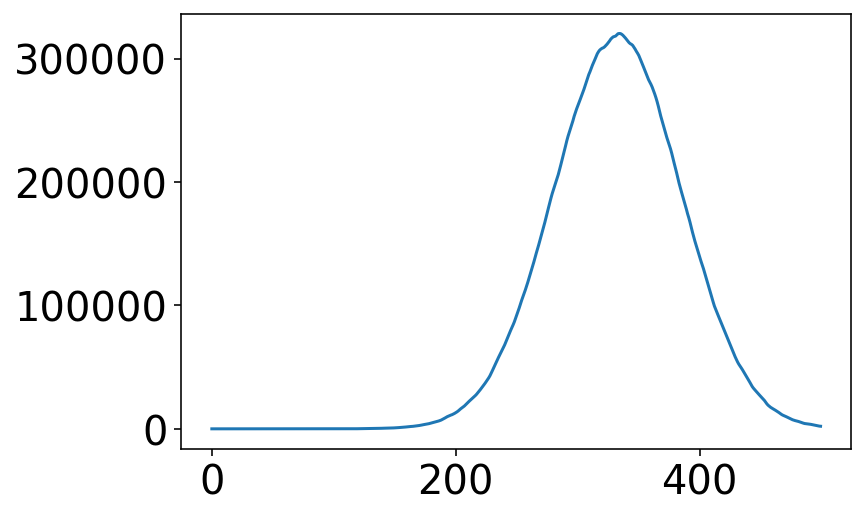

In [7]:
# Sanity check. The peak of Case A Ws should be around 3e5 (1/m^2)
plt.plot(Ws_along_x_observe * factor_case_A *dz*dx)

In [8]:
#def aaa(xo):
#    return boundary_convolve('A', lambda_grid_filtered, Es_grid, Fx_grid, xvec, xo, zvec2, xvec2, beta=beta, rho=rho, phi=phi)
def aaa(xo):
    return boundary_convolve('A', xo, xvec=xvec, zvec2=zvec2, xvec2=xvec2, 
                  G_lamb = lambda_grid_filtered, Gs=Es_grid, Gx=Fx_grid, 
                  beta=beta, rho=rho, phi=phi)

In [9]:
with cf.ProcessPoolExecutor(max_workers=20) as executor:
    result = executor.map(aaa, xvec)
    gg = np.array(list(result))
    
Ws_grid  = gg[:,0,:] * factor_case_A * (dz*dx)
Wx_grid  = gg[:,1,:] * factor_case_A * (dz*dx)

Text(0.5, 0.92, '$W_x$ Case A')

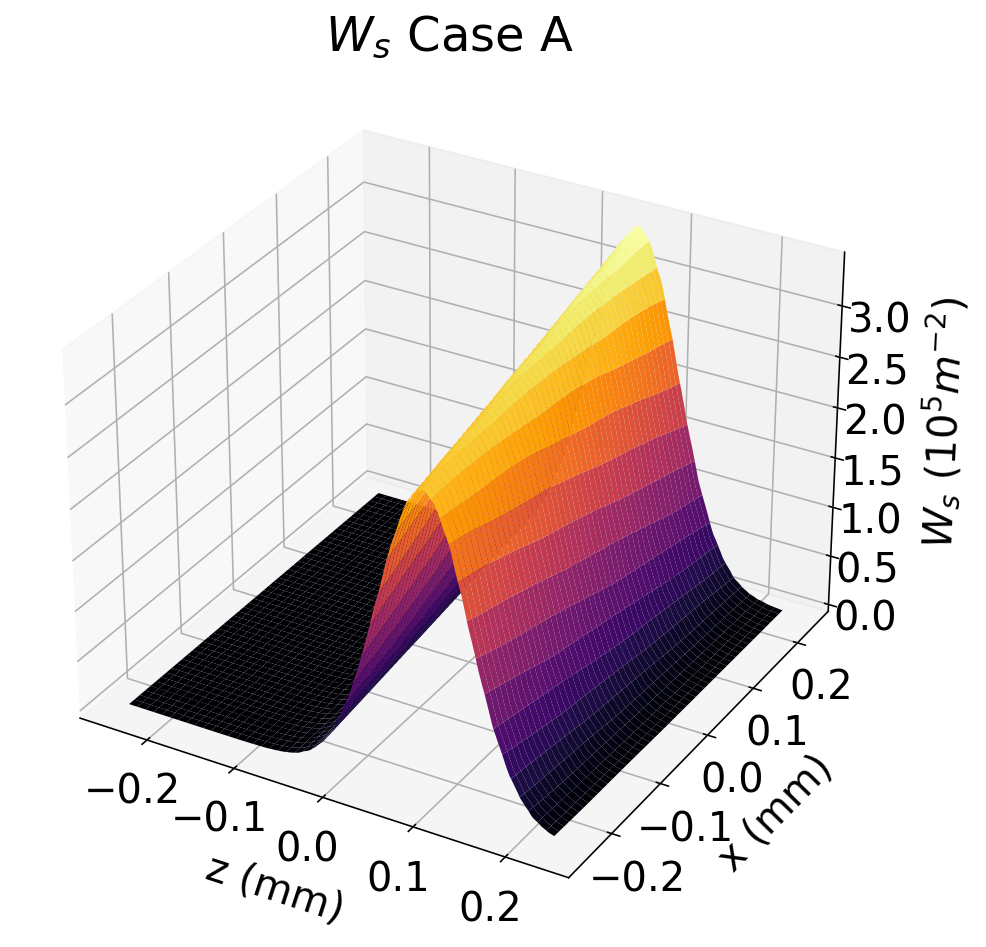

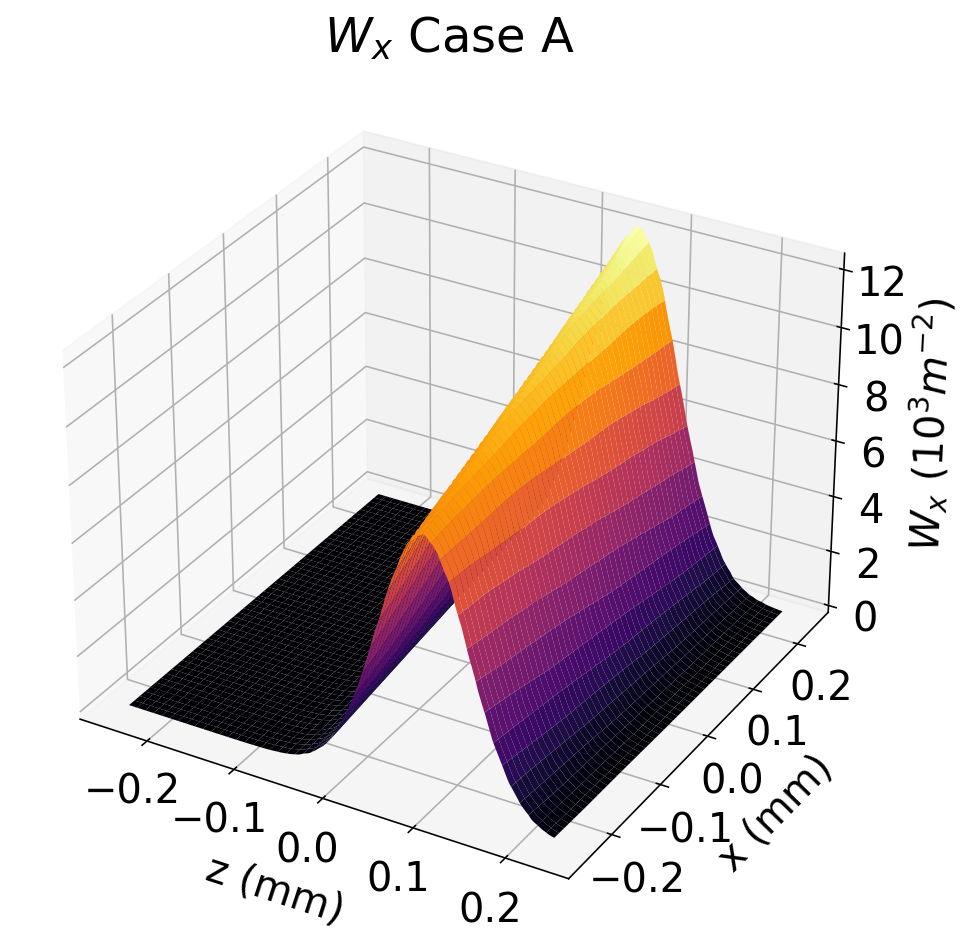

In [10]:
from mpl_toolkits import mplot3d
Z, X = np.meshgrid(zvec*1e3, xvec*1e3, indexing="ij")

labelpad = 12

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z,X, Ws_grid.T*1e-5, cmap='inferno')
ax.set_xlabel('z (mm)', labelpad=labelpad )
ax.set_ylabel('x (mm)', labelpad=labelpad )
ax.set_zlabel(r'$W_s~(10^5m^{-2})$', labelpad=labelpad )
ax.set_title(r'$W_s$ Case A')

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z,X, Wx_grid.T*1e-3, cmap='inferno')
ax.set_xlabel('z (mm)', labelpad=labelpad )
ax.set_ylabel('x (mm)', labelpad=labelpad )
ax.set_zlabel(r'$W_x~(10^3 m^{-2})$', labelpad=8 )
ax.set_title(r'$W_x$ Case A')

## Case C

In [13]:
t1 = time.time()
Es_grid, Fx_grid, zvec2, xvec2 = \
compute_potential_grids('C', nz=Nz, nx=Nx, dz=dz, dx=dx, rho=rho, beta=beta, phi_m=phi_m, lamb = lamb )

t2 = time.time()
print('Computing potential grids takes: ',t2-t1, 'sec')

Computing potential grids takes:  0.20770645141601562 sec


In [14]:
#def ccc(xo):
#    return boundary_convolve('C', lambda_grid_filtered, Es_grid, Fx_grid, xvec, xo, zvec2, xvec2, beta=beta, rho=rho, phi_m=phi_m, lamb=lamb)

def ccc(xo):
    return boundary_convolve('C', xo, xvec=xvec, zvec2=zvec2, xvec2=xvec2, 
                  G_lamb = lambda_grid_filtered, Gs=Es_grid, Gx=Fx_grid, 
                  beta=beta, rho=rho, phi_m=phi_m, lamb=lamb)

In [15]:
with cf.ProcessPoolExecutor(max_workers=20) as executor:
    result = executor.map(ccc, xvec)
    gg = np.array(list(result))
    
Ws_grid  = gg[:,0,:] * factor_case_C * (dz*dx)
Wx_grid  = gg[:,1,:] * factor_case_C * (dz*dx)

Text(0.5, 0.92, '$W_x$ Case C')

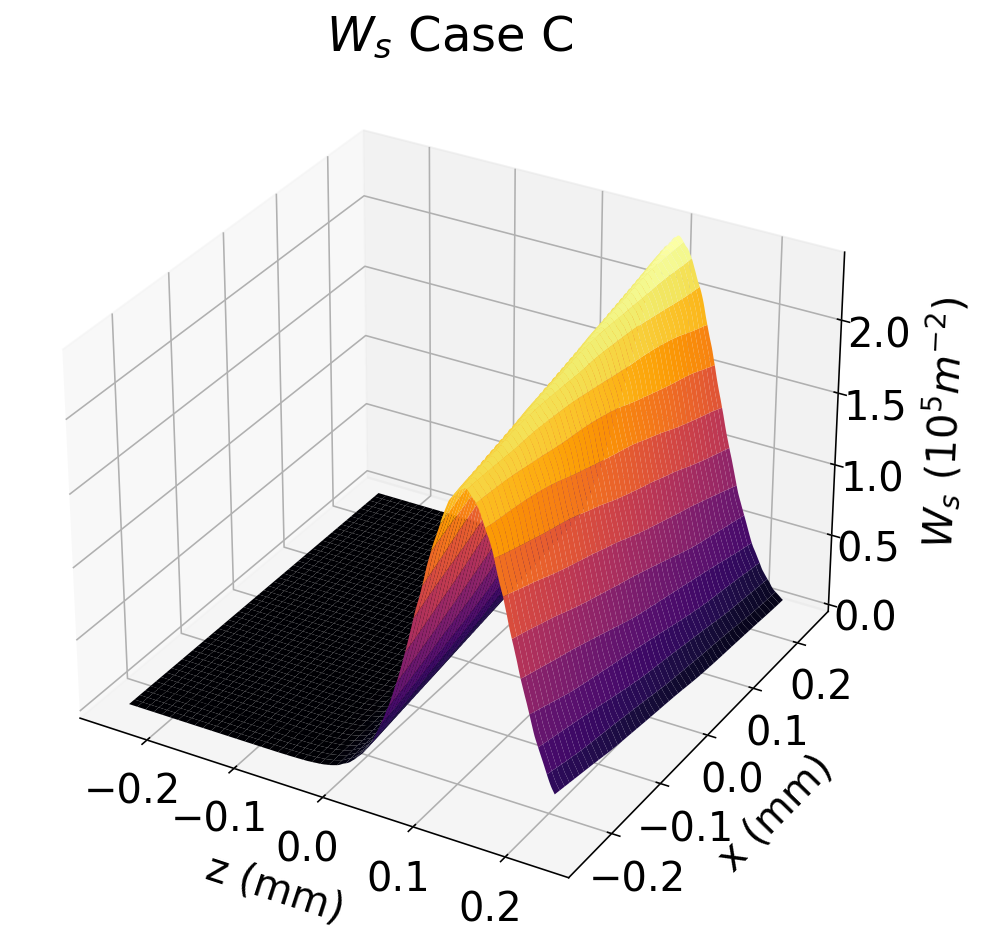

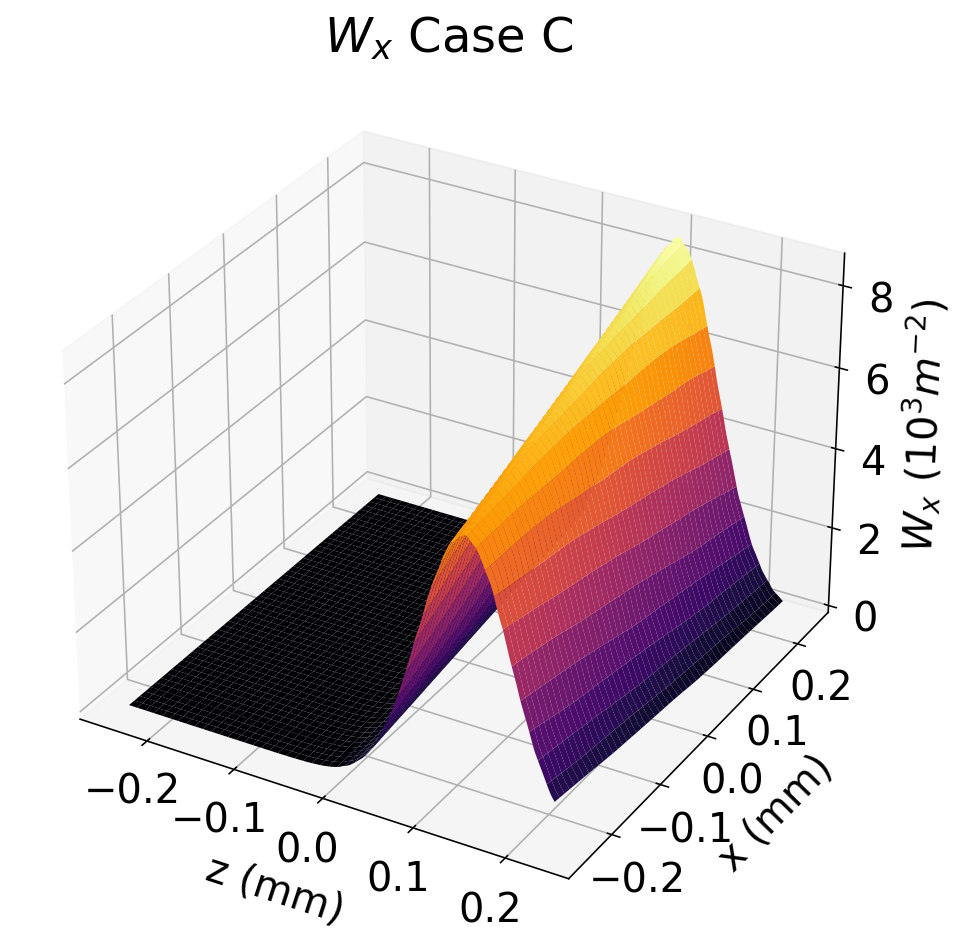

In [16]:
Z, X = np.meshgrid(zvec*1e3, xvec*1e3, indexing="ij")

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z,X, Ws_grid.T*1e-5, cmap='inferno')
ax.set_xlabel('z (mm)', labelpad=labelpad)
ax.set_ylabel('x (mm)', labelpad=labelpad)
ax.set_zlabel(r'$W_s~(10^5 m^{-2})$', labelpad=labelpad)
ax.set_title(r'$W_s$ Case C')

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z,X, Wx_grid.T*1e-3, cmap='inferno')
ax.set_xlabel('z (mm)', labelpad=labelpad)
ax.set_ylabel('x (mm)', labelpad=labelpad)
ax.set_zlabel(r'$W_x~(10^3 m^{-2})$', labelpad=6)
ax.set_title(r'$W_x$ Case C')

## Case B

In [19]:
t1 = time.time()
psi_s_grid, psi_x_grid, zvec2, xvec2 = \
compute_potential_grids('B', nz=Nz, nx=Nx, dz=dz, dx=dx, rho=rho, beta=beta )

t2 = time.time()
print('Computing potential grids takes: ',t2-t1, 'sec')

Computing potential grids takes:  0.22006797790527344 sec


In [20]:
def bbb(xo):
    return boundary_convolve('B', xo, zvec=zvec, xvec=xvec, zvec2=zvec2, xvec2=xvec2, 
                  G_lamb = lambda_grid_filtered, G_lamb_p = lambda_grid_filtered_prime, Gs=psi_s_grid, Gx=psi_x_grid, 
                  beta=beta, rho=rho, phi=phi, dx=dx)

In [24]:
with cf.ProcessPoolExecutor(max_workers=20) as executor:
    result = executor.map(bbb, xvec)
    gg = np.array(list(result))
    
#Ws_grid  = gg[:,0,:] * factor_case_B * (dz*dx)
#Wx_grid  = gg[:,1,:] * factor_case_B * (dz*dx)

In [29]:
Ws_grid  = factor_case_B * (gg[:,0,:]*(dz*dx) + gg[:,1,:]*dx + gg[:,2,:]*dx)
Wx_grid  = factor_case_B * (gg[:,3,:]*(dz*dx) + gg[:,4,:]*dx + gg[:,5,:]*dx)

Text(0.5, 0.92, '$W_x$ Case B')

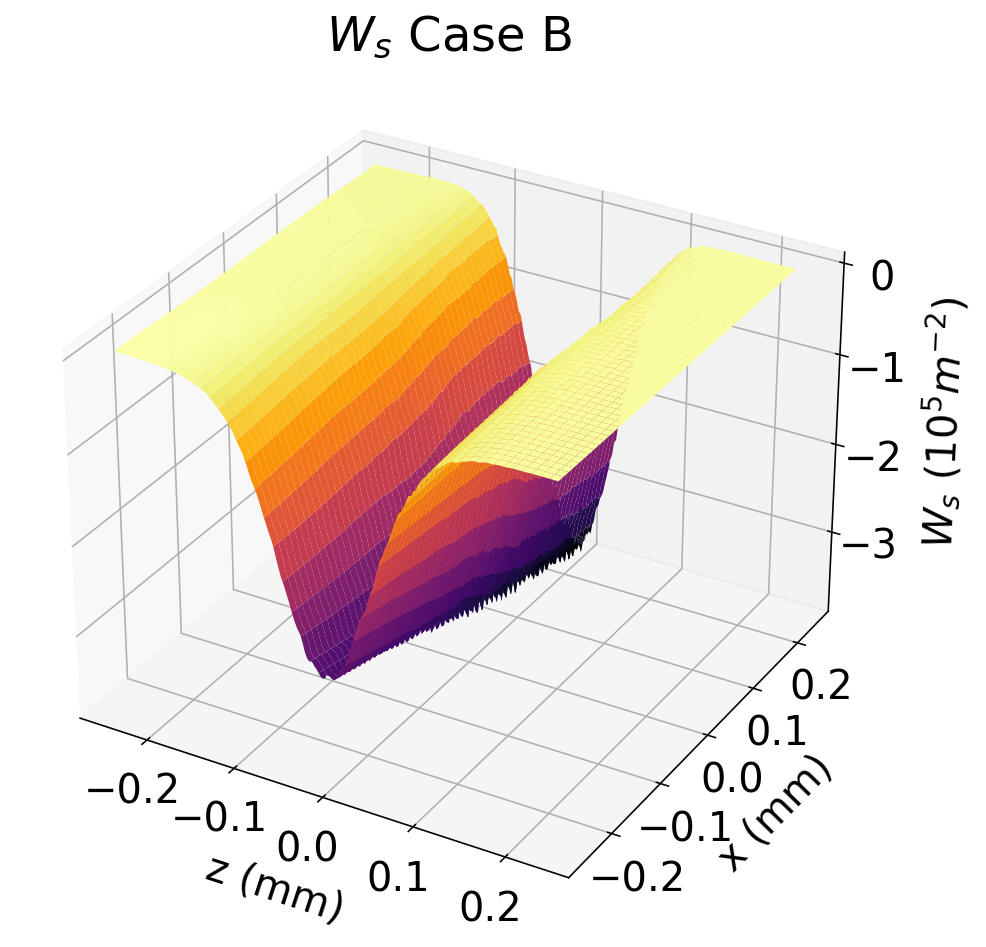

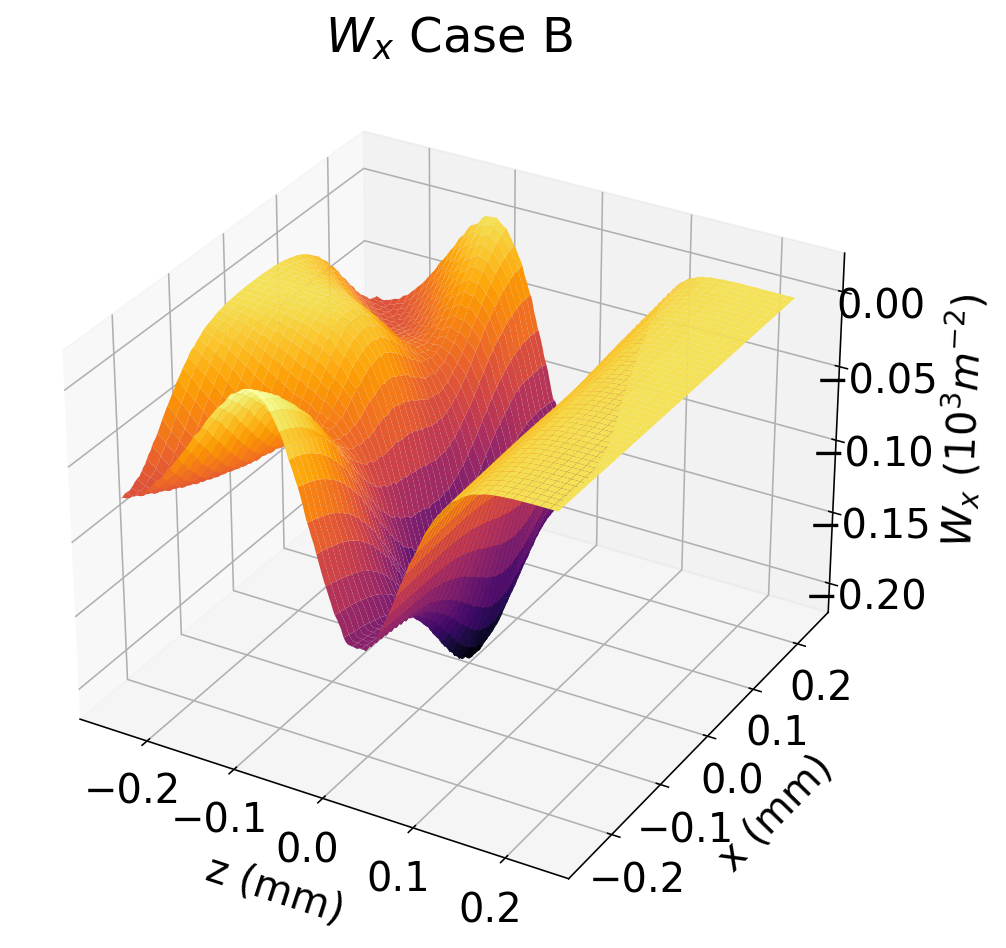

In [32]:
Z, X = np.meshgrid(zvec*1e3, xvec*1e3, indexing="ij")

labelpad = 12

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z,X, Ws_grid.T*1e-5, cmap='inferno')
ax.set_xlabel('z (mm)', labelpad=labelpad)
ax.set_ylabel('x (mm)', labelpad=labelpad)
ax.set_zlabel(r'$W_s~(10^5 m^{-2})$', labelpad=labelpad)
ax.set_title(r'$W_s$ Case B')

fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Z,X, Wx_grid.T*1e-5, cmap='inferno')
ax.set_xlabel('z (mm)', labelpad=labelpad)
ax.set_ylabel('x (mm)', labelpad=labelpad)
ax.set_zlabel(r'$W_x~(10^3 m^{-2})$', labelpad=18)
ax.set_title(r'$W_x$ Case B')